In [61]:
import random
import pandas as pd
import scipy.stats as stats
import matplotlib.pyplot as plt
import itertools
import numpy as np

# Data Representation

In [27]:
class Course:
    def __init__(self, course_id, professors):
        self.course_id = course_id
        self.professors = professors  # List of Professor objects

class Class:
    def __init__(self, class_id, total_weekly_hours, courses, time_slots):
        self.class_id = class_id
        self.total_weekly_hours = total_weekly_hours
        self.courses = courses  # List of tuples (Course object, weekly hours for this course)
        self.time_slots = time_slots  # Set of tuples (day, time)

class Professor:
    def __init__(self, professor_id, available_slots):
        self.professor_id = professor_id
        self.available_slots = available_slots  # Set of time slots

class Schedule:
    def __init__(self, classes, professors, courses):
        self.entries = []
        self.classes = {cls.class_id: cls for cls in classes}
        self.professors = {prof.professor_id: prof for prof in professors}
        self.courses = {course.course_id: course for course in courses}
        self.professor_allocations = {prof.professor_id: set() for prof in professors}

    def add_entry(self, time_slot, class_id, course_id, professor_id):
        self.entries.append((time_slot, class_id, course_id, professor_id))

    def is_class_course_hour_satisfied(self):
        course_hours = {(cls.class_id, course.course_id): 0 for cls in self.classes.values() for course, _ in cls.courses}
        for time_slot, class_id, course_id, _ in self.entries:
            course_hours[(class_id, course_id)] += 1

        for cls in self.classes.values():
            for course, required_hours in cls.courses:
                if course_hours[(cls.class_id, course.course_id)] != required_hours:
                    return False
        return True

    def is_class_total_hour_satisfied(self):
        class_hours = {cls.class_id: 0 for cls in self.classes.values()}
        for time_slot, class_id, _, _ in self.entries:
            class_hours[class_id] += 1

        for cls in self.classes.values():
            if class_hours[cls.class_id] != cls.total_weekly_hours:
                return False
        return True

    def difference_class_course_hour(self):
        course_hours = {(cls.class_id, course.course_id): 0 for cls in self.classes.values() for course, _ in cls.courses}
        for time_slot, class_id, course_id, _ in self.entries:
            course_hours[(class_id, course_id)] += 1

        total_diff = 0
        for cls in self.classes.values():
            for course, required_hours in cls.courses:
                total_diff += abs(course_hours[(cls.class_id, course.course_id)] - required_hours)
        return total_diff

    def difference_class_total_hour(self):
        class_hours = {cls.class_id: 0 for cls in self.classes.values()}
        for time_slot, class_id, _, _ in self.entries:
            class_hours[class_id] += 1

        total_diff = 0
        for cls in self.classes.values():
            total_diff += abs(class_hours[cls.class_id] - cls.total_weekly_hours)
        return total_diff

    def is_hard_constraints_satisfied(self):
        # Check if a class is scheduled for more than one course at the same time
        class_time_allocations = {}
        for time_slot, class_id, _, _ in self.entries:
            if (class_id, time_slot) in class_time_allocations:
                return False  # Class is double-booked
            class_time_allocations[(class_id, time_slot)] = True
        # Check if a professor is teaching more than one class at the same time
        professor_time_allocations = {}
        for time_slot, _, _, professor_id in self.entries:
            if (professor_id, time_slot) in professor_time_allocations:
                return False  # Professor is double-booked
            professor_time_allocations[(professor_id, time_slot)] = True
        # Check if professors are teaching according to their available periods
        for time_slot, _, _, professor_id in self.entries:
            if time_slot not in self.professors[professor_id].available_slots:
                return False  # Professor is teaching outside their available period
        return True

    def correct_schedule(self):
        # Initial correction for double-booked classes and professors
        self.remove_conflicting_entries()

        # Try to reschedule to meet course and total hour requirements
        self.reschedule_entries()

        if not self.is_hard_constraints_satisfied():
            raise Exception("Hard Constraint not satisfied after correction!")


    def remove_conflicting_entries(self):
        corrected_entries = []
        class_time_allocations = {}
        professor_time_allocations = {}

        for time_slot, class_id, course_id, professor_id in self.entries:
            # Check if the class or professor is already booked at this time slot
            if (class_id, time_slot) in class_time_allocations or (professor_id, time_slot) in professor_time_allocations:
                continue  # Skip this entry, as it violates a hard constraint

            # Check if the professor is available at this time slot
            if time_slot not in self.professors[professor_id].available_slots:
                continue  # Skip this entry, as the professor is not available

            # Add the entry to the corrected list and mark the time slot as booked
            corrected_entries.append((time_slot, class_id, course_id, professor_id))
            class_time_allocations[(class_id, time_slot)] = True
            professor_time_allocations[(professor_id, time_slot)] = True

        # Replace the schedule's entries with the corrected list
        self.entries = corrected_entries

    def reschedule_entries(self, stale_update_limit=10):
        # Create all combinations of class, course, and hours
        scheduled_hours = {(class_id, course.course_id): 0 for class_id in self.classes for course, _ in self.classes[class_id].courses}
        for _, class_id, course_id, _ in self.entries:
            scheduled_hours[(class_id, course_id)] += 1

        combinations = []
        for class_obj in self.classes.values():
            for course, required_hours in class_obj.courses:
                scheduled = scheduled_hours.get((class_obj.class_id, course.course_id), 0)
                remaining_hours = required_hours - scheduled
                for _ in range(remaining_hours):
                    combinations.append((class_obj, course))

        random.shuffle(combinations)  # Shuffle combinations for randomness

        # maybe this below function could be a function of its own since it's repeated later
        stale_counter = 0

        while combinations and stale_counter < stale_update_limit:
            prev_combinations = combinations.copy()

            for class_obj, course in prev_combinations:
                potential_professors = [prof for prof in self.professors.values() if prof in course.professors]
                random.shuffle(potential_professors)  # Shuffle potential professors for fairness

                class_available_slots = set(class_obj.time_slots)
                # Eliminate slots where the class is already booked
                for entry in self.entries:
                    if entry[1] == class_obj.class_id:
                        class_available_slots.discard(entry[0])

                for professor in potential_professors:
                    professor_available_slots = set(professor.available_slots)
                    # Eliminate slots where the professor is already booked or not available
                    for entry in self.entries:
                        if entry[3] == professor.professor_id or entry[0] not in professor_available_slots:
                            professor_available_slots.discard(entry[0])

                    available_slots = class_available_slots.intersection(professor_available_slots)
                    if available_slots:
                        time_slot = random.choice(list(available_slots))
                        self.add_entry(time_slot, class_obj.class_id, course.course_id, professor.professor_id)
                        combinations.remove((class_obj, course))
                        stale_counter = 0
                        break  # Break out of the professor loop once a slot is assigned

            # Check if no progress was made in the loop
            if prev_combinations == combinations:
                stale_counter += 1  # Increment stale counter

            # Break if stale counter reaches the update limit
            if stale_counter >= stale_update_limit:
                break

    def to_df(self):
        data = []
        for entry in self.entries:
            time_slot, class_id, course_id, professor_id = entry
            data.append({"Time Slot": time_slot, "Class ID": class_id, "Course ID": course_id, "Professor ID": professor_id})

        df = pd.DataFrame(data)
        df.set_index(["Time Slot", "Class ID"], inplace=True)

        # Creating a multi-index for all combinations of time slots and class IDs
        all_time_slots = set(slot for class_obj in self.classes.values() for slot in class_obj.time_slots)
        all_class_ids = [class_obj.class_id for class_obj in self.classes.values()]
        multi_index = pd.MultiIndex.from_product([all_time_slots, all_class_ids], names=["Time Slot", "Class ID"])

        return df.reindex(multi_index)

    def to_df_class_indexed(self):
        # Mapping for days and hours
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        hours = [f"{h + 8} AM" if h < 4 else f"{h - 4} PM" for h in range(9)]

        # Create a dictionary to hold the data
        data = {(hour, class_id): {day: [] for day in days} for hour in hours for class_id in self.classes}

        # Populate the dictionary with schedule entries
        for (day_num, hour_num), class_id, course_id, professor_id in self.entries:
            day = days[day_num]
            hour = hours[hour_num]
            data[(hour, class_id)][day].append((course_id, professor_id))

        # Convert the dictionary to a DataFrame
        df = pd.DataFrame(data).T  # Transpose to get days as columns
        df.index.names = ['Hour', 'Class ID']

        return df

    def to_df_professor_indexed(self):
        # Mapping for days and hours
        days = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday']
        hours = [f"{h + 8} AM" if h < 4 else f"{h - 4} PM" for h in range(9)]

        # Create a dictionary to hold the data
        data = {(hour, professor_id): {day: [] for day in days} for hour in hours for professor_id in self.professors}

        # Populate the dictionary with schedule entries
        for (day_num, hour_num), class_id, course_id, professor_id in self.entries:
            day = days[day_num]
            hour = hours[hour_num]
            data[(hour, professor_id)][day].append((course_id, class_id))

        # Convert the dictionary to a DataFrame
        df = pd.DataFrame(data).T  # Transpose to get days as columns
        df.index.names = ['Hour', 'Professor ID']

        return df


# Selection Strategies

In [3]:
from abc import ABC, abstractmethod

def shift_fitness_range(fitnesses):
    min_fitness = min(fitnesses)
    if min_fitness < 0:
        shift_value = abs(min_fitness)
        fitnesses = [fit + shift_value for fit in fitnesses]
    return fitnesses


class SelectionStrategy(ABC):
    @abstractmethod
    def select(self, population, fitnesses, num_parents):
        pass

class BattleRoyaleTournamentSelection(SelectionStrategy):
    def __init__(self, n_participants):
        self.n_participants = n_participants

    def select(self, population, fitnesses, num_parents):
        selected_parents = []
        fitnesses = shift_fitness_range(fitnesses)
        for _ in range(num_parents):
            # Randomly select individuals for the tournament
            tournament_individuals = random.sample(list(zip(population, fitnesses)), self.n_participants)

            # Select the individual with the highest fitness
            # Weighted random choice based on fitness
            winner = random.choices(tournament_individuals, weights=[fit for _, fit in tournament_individuals], k=1)[0]
            selected_parents.append(winner[0])

        return selected_parents


class RandomWeightedSelection(SelectionStrategy):
    def select(self, population, fitnesses, num_parents):
        fitnesses = shift_fitness_range(fitnesses)
        return random.choices(population, weights=fitnesses, k=num_parents)


class SingleEliminationTournamentSelection(SelectionStrategy):
    def __init__(self, n_participants):
        self.n_participants = n_participants

    def select(self, population, fitnesses, num_parents):
        selected_parents = []
        fitnesses = shift_fitness_range(fitnesses)
        for _ in range(num_parents):
            # Randomly select n_participants for the tournament
            tournament_individuals = random.sample(list(zip(population, fitnesses)), self.n_participants)

            # Perform a Single Elimination tournament
            while len(tournament_individuals) > 1:
                pairs = [tournament_individuals[i:i+2] for i in range(0, len(tournament_individuals), 2)]
                winners = []
                for pair in pairs:
                    if len(pair) == 2:
                        # Choose winner based on fitness as weights
                        winner = random.choices(pair, weights=[fit for _, fit in pair], k=1)[0]
                        winners.append(winner)
                    else:
                        # If only one participant remains, it automatically wins
                        winners.append(pair[0])
                tournament_individuals = winners

            # Select the individual that reached the end (winner)
            winner = tournament_individuals[0][0]
            selected_parents.append(winner)

        return selected_parents

class RoundRobinTournamentSelection(SelectionStrategy):
    def __init__(self, n_participants):
        self.n_participants = n_participants

    def select(self, population, fitnesses, num_parents):
        selected_parents = []
        fitnesses = shift_fitness_range(fitnesses)
        for _ in range(num_parents):
            # Randomly select n_participants for the tournament
            tournament_individuals = random.sample(list(zip(population, fitnesses)), self.n_participants)

            # Initialize scores for each individual
            scores = {individual: 0 for individual, _ in tournament_individuals}

            # Perform a Round-Robin tournament
            for i in range(len(tournament_individuals)):
                for j in range(i + 1, len(tournament_individuals)):
                    competitors = [tournament_individuals[i], tournament_individuals[j]]
                    winner = random.choices(competitors, weights=[fit for _, fit in competitors], k=1)[0]
                    scores[winner[0]] += 1

            # Select the individual with the highest overall score
            winner = max(scores, key=scores.get)
            selected_parents.append(winner)

        return selected_parents



# Initial Generation

In [4]:
import random

def generate_random_schedule(classes, professors, courses, stale_update_limit):
    schedule = Schedule(classes, professors, courses)

    # Create all combinations of class, course, and hours
    combinations = []
    for class_obj in classes:
        for course, hours in class_obj.courses:
            for _ in range(hours):
                combinations.append((class_obj, course))


    random.shuffle(combinations)  # Shuffle combinations for randomness

    stale_counter = 0

    while combinations and stale_counter < stale_update_limit:
        prev_combinations = combinations.copy()

        for class_obj, course in prev_combinations:
            potential_professors = [prof for prof in professors if prof in course.professors]
            random.shuffle(potential_professors)  # Shuffle potential professors for fairness

            class_available_slots = set(class_obj.time_slots)
            # Eliminate slots where the class is already booked
            for entry in schedule.entries:
                if entry[1] == class_obj.class_id:
                    class_available_slots.discard(entry[0])

            for professor in potential_professors:
                professor_available_slots = set(professor.available_slots)
                # Eliminate slots where the professor is already booked or not available
                for entry in schedule.entries:
                    if entry[3] == professor.professor_id or entry[0] not in professor_available_slots:
                        professor_available_slots.discard(entry[0])

                available_slots = class_available_slots.intersection(professor_available_slots)
                if available_slots:
                    time_slot = random.choice(list(available_slots))
                    schedule.add_entry(time_slot, class_obj.class_id, course.course_id, professor.professor_id)
                    combinations.remove((class_obj, course))
                    stale_counter = 0
                    break  # Break out of the professor loop once a slot is assigned

        # Check if no progress was made in the loop
        if prev_combinations == combinations:
            stale_counter += 1  # Increment stale counter

        # Break if stale counter reaches the update limit
        if stale_counter >= stale_update_limit:
            break

    if not schedule.is_hard_constraints_satisfied():
        raise Exception("Hard Constraint not satisfied for this schedule!")

    return schedule

# Main Evolutionary Algorithm Functions

In [43]:
import statistics

def mutate_schedule(schedule):
    if not schedule.entries:
        return

    # Randomly pick an entry to remove
    entry_index = random.randint(0, len(schedule.entries) - 1)
    schedule.entries.pop(entry_index)

    # Correct the schedule to fill in the gap while respecting hard constraints
    schedule.correct_schedule()

def crossover(schedule1, schedule2):
    # Convert dictionaries back to lists for creating a new schedule
    classes_list = list(schedule1.classes.values())
    professors_list = list(schedule1.professors.values())
    courses_list = list(schedule1.courses.values())

    # Create a new child schedule
    child_schedule = Schedule(classes_list, professors_list, courses_list)

    # Combine entries from both parent schedules
    half = len(schedule1.entries) // 2
    child_schedule.entries = schedule1.entries[:half] + schedule2.entries[half:]

    # Correct the schedule to conform to hard constraints
    child_schedule.correct_schedule()

    return child_schedule

# Function to convert time slot tuple into a single numeric value
def time_slot_to_numeric(time_slot, study_hour_per_day=8):
    day, hour = time_slot
    return day * study_hour_per_day + hour  # Assuming 8 hours per day

# deprecated for classes instead
# def tournament_selection(population, fitnesses, tournament_size, num_parents):
#     selected_parents = []
#
#     for _ in range(num_parents):
#         # Randomly select individuals for the tournament
#         tournament_individuals = random.sample(list(zip(population, fitnesses)), tournament_size)
#
#         # Select the individual with the highest fitness
#         winner = max(tournament_individuals, key=lambda x: x[1])
#         selected_parents.append(winner[0])
#
#     return selected_parents
def calculate_class_consecutive_hours_penalty(schedule):
    penalty = 0
    # Create a mapping of class schedules by day and hour
    class_schedule_map = {class_id: {day: [False] * 9 for day in range(5)} for class_id in schedule.classes}
    for time_slot, class_id, _, _ in schedule.entries:
        day, hour = time_slot
        class_schedule_map[class_id][day][hour] = True

    # Calculate penalty based on consecutive hours
    for class_id, day_schedule in class_schedule_map.items():
        for day, hours in day_schedule.items():
            consecutive_hours = 0
            for hour in hours:
                if hour:
                    consecutive_hours += 1
                    if consecutive_hours > 3:
                        penalty += 1
                else:
                    consecutive_hours = 0
    return penalty

def calculate_professor_consecutive_hours_penalty(schedule):
    penalty = 0
    # Create a mapping of professor schedules by day and hour
    professor_schedule_map = {professor_id: {day: [False] * 9 for day in range(5)} for professor_id in schedule.professors}
    for time_slot, _, _, professor_id in schedule.entries:
        day, hour = time_slot
        professor_schedule_map[professor_id][day][hour] = True

    # Calculate penalty based on consecutive hours
    for professor_id, day_schedule in professor_schedule_map.items():
        for day, hours in day_schedule.items():
            consecutive_hours = 0
            for hour in hours:
                if hour:
                    consecutive_hours += 1
                    if consecutive_hours > 3:
                        penalty += 1
                else:
                    consecutive_hours = 0
    return penalty


def penalize_large_gap(schedule):
    # Create a dictionary mapping class_id to entries organized by day
    class_id_to_entries_by_day = {class_id: {day: [] for day in range(5)} for class_id in schedule.classes}
    for time_slot, class_id, _, _ in schedule.entries:
        day, hour = time_slot
        class_id_to_entries_by_day[class_id][day].append(hour)

    gap_penalty = 0
    for class_id, entries_by_day in class_id_to_entries_by_day.items():
        for day, hours in entries_by_day.items():
            if hours:  # Check if there are any entries for that day
                sorted_hours = sorted(hours)
                for i in range(1, len(sorted_hours)):
                    gap = sorted_hours[i] - sorted_hours[i - 1]
                    if gap > 1:
                        gap_penalty += gap - 1  # Penalize gaps larger than 1 hour

    return gap_penalty

def evaluate_fitness(schedule, study_hour_per_day=8):
    fitness = 0

    if schedule.is_class_course_hour_satisfied() and schedule.is_class_total_hour_satisfied():
        fitness += 1000  # High base score for meeting basic requirements

    # Bonus for finishing classes earlier
    for class_id, cls in schedule.classes.items():
        last_time_slot = max(time_slot_to_numeric(entry[0], study_hour_per_day) for entry in schedule.entries if entry[1] == class_id)
        max_time_slot = max(time_slot_to_numeric(slot, study_hour_per_day) for slot in cls.time_slots)
        fitness += (max_time_slot - last_time_slot)*100  # Earlier finish yields higher fitness

    # Calculate the standard deviation of teaching hours across professors
    professor_teaching_hours = {professor_id: 0 for professor_id in schedule.professors}
    for _, _, _, professor_id in schedule.entries:
        professor_teaching_hours[professor_id] += 1

    # Penalize schedules with large gaps between classes
    fitness -= penalize_large_gap(schedule) * 50  # Penalize gaps

    # Apply a penalty for many consecutive teachings
    fitness -= calculate_professor_consecutive_hours_penalty(schedule) * 50

    # Apply a penalty for many consecutive classes
    fitness -= calculate_class_consecutive_hours_penalty(schedule) * 50

    # Apply a penalty for variance in teaching hours
    teaching_hours_std_dev = statistics.stdev(professor_teaching_hours.values())
    fitness -= teaching_hours_std_dev * 100  # Penalty based on standard deviation

    # Penalties - Since we have bonuses, we should also have penalties
    fitness -= schedule.difference_class_course_hour() * 100  # Penalty for each hour mismatch in courses
    fitness -= schedule.difference_class_total_hour() * 100   # Penalty for each hour mismatch in total hours

    return fitness

def evolutionary_algorithm(classes, professors, courses, num_generations, population_size, stale_limit, mutation_rate, selection_strategy):
    population = [generate_random_schedule(classes, professors, courses, stale_limit) for _ in range(population_size)]
    best_schedule = None
    best_fitness = float('-inf')

    for _ in range(num_generations):
        fitnesses = [evaluate_fitness(schedule) for schedule in population]

        # Update the best schedule found so far
        for i, fitness in enumerate(fitnesses):
            if fitness > best_fitness:
                best_fitness = fitness
                best_schedule = population[i]

        new_population = []
        while len(new_population) < population_size:
            parents = selection_strategy.select(population, fitnesses, 2)
            child = crossover(parents[0], parents[1])

            if random.random() < mutation_rate:
                mutate_schedule(child)

            new_population.append(child)

        population = new_population

    return best_schedule, best_fitness


In [ ]:
# check if schedule meets the requirement of weekly hour persubject per class
def test_initial_schedule_generation(num_schedules, classes, professors, courses, stale_limit):
    for _ in range(num_schedules):
        schedule = generate_random_schedule(classes, professors, courses, stale_limit)
        if not schedule.is_hard_constraints_satisfied():
            return False  # Found a schedule that violates hard constraints
    return True  # All generated schedules satisfy hard constraints

# Experimentation Functions

In [67]:
def simulate_multiple_runs_given_configuration_and_strategies(classes,
                                                              courses,
                                                              professors,
                                                              num_generations = 100,
                                                              population_size = 50,
                                                              stale_limit = 10,
                                                              mutation_rate = 0.1,
                                                              participants_per_tournament=16,
                                                              runs_per_strategy=100):
    result_dict = {
        'random': [],
        'battle_royale': [],
        'round_robin': [],
        'single_elim': []
    }
    best_schedule_per_tour = {
        'random': (None, 0),
        'battle_royale': (None, 0),
        'round_robin': (None, 0),
        'single_elim': (None, 0)
    }
    for _ in range(runs_per_strategy):
        # Random
        selection_strategy_tournament = RandomWeightedSelection()
        best_schedule_rn, best_fitness_rn = evolutionary_algorithm(classes, professors, courses, num_generations, population_size, stale_limit, mutation_rate, selection_strategy_tournament)
        result_dict['random'].append(best_fitness_rn)
        if best_schedule_per_tour['random'][1] < best_fitness_rn:
            best_schedule_per_tour['random'] = (best_schedule_rn, best_fitness_rn)

        # Battle Royale Tournameny
        selection_strategy_tournament = BattleRoyaleTournamentSelection(participants_per_tournament)
        best_schedule_br, best_fitness_br = evolutionary_algorithm(classes, professors, courses, num_generations, population_size, stale_limit, mutation_rate, selection_strategy_tournament)
        result_dict['battle_royale'].append(best_fitness_br)
        if best_schedule_per_tour['battle_royale'][1] < best_fitness_br:
            best_schedule_per_tour['battle_royale'] = (best_schedule_br, best_fitness_br)

        # Round-Robin Tournament
        selection_strategy_tournament = RoundRobinTournamentSelection(participants_per_tournament)
        best_schedule_rr, best_fitness_rr = evolutionary_algorithm(classes, professors, courses, num_generations, population_size, stale_limit, mutation_rate, selection_strategy_tournament)
        result_dict['round_robin'].append(best_fitness_rr)
        if best_schedule_per_tour['round_robin'][1] < best_fitness_rr:
            best_schedule_per_tour['round_robin'] = (best_schedule_rr, best_fitness_rr)

        # Single Elimination
        selection_strategy_tournament = SingleEliminationTournamentSelection(participants_per_tournament)
        best_schedule_se, best_fitness_se = evolutionary_algorithm(classes, professors, courses, num_generations, population_size, stale_limit, mutation_rate, selection_strategy_tournament)
        result_dict['single_elim'].append(best_fitness_se)
        if best_schedule_per_tour['single_elim'][1] < best_fitness_se:
            best_schedule_per_tour['single_elim'] = (best_schedule_se, best_fitness_se)
    return pd.DataFrame(result_dict), best_schedule_per_tour


def plot_fitness_distribution(df, num_bins=10):
    # Determine the range for the bins
    min_fitness = min(df.min())
    max_fitness = max(df.max())
    bins = np.linspace(min_fitness, max_fitness, num_bins)

    # Calculate histogram data for each strategy
    histogram_data = {}
    for strategy in df.columns:
        histogram_data[strategy], _ = np.histogram(df[strategy].dropna(), bins)

    # Plotting the stacked bar plot
    plt.figure(figsize=(12, 6))
    bottom_values = np.zeros(num_bins - 1)
    for strategy, data in histogram_data.items():
        plt.bar(bins[:-1], data, bottom=bottom_values, label=strategy, width=np.diff(bins), align="edge", alpha=0.7)
        bottom_values += data

    plt.xlabel('Fitness')
    plt.ylabel('Frequency')
    plt.title('Stacked Fitness Distribution of Selection Strategies')
    plt.legend()
    plt.xticks(bins)
    plt.show()

def test_normality(df):
    normality_results = pd.DataFrame(columns=["p-value", "follow_normality"])

    for strategy in df.columns:
        _, p_value = stats.shapiro(df[strategy].dropna())
        normality_results.loc[strategy] = [p_value, p_value > 0.05]
    # return df, is_all_follow_normal
    return normality_results, all(normality_results['follow_normality'])

def perform_anova_or_kruskal(df, is_all_follow_normal):
    # Flatten the dataframe and perform normality test
    flattened_data = [df[col].dropna() for col in df.columns]

    if is_all_follow_normal:
        _, p_value_anova = stats.f_oneway(*flattened_data)
        return True, p_value_anova  # True indicates ANOVA was used
    else:
        _, p_value_kruskal = stats.kruskal(*flattened_data)
        return False, p_value_kruskal  # False indicates Kruskal-Wallis was used

def pairwise_tests(df, is_all_follow_normality):
    pairwise_results = []

    for strategy1, strategy2 in itertools.combinations(df.columns, 2):
        if is_all_follow_normality:
            # Use Student's t-test (for normally distributed data)
            _, p_value = stats.ttest_ind(df[strategy1].dropna(), df[strategy2].dropna(), equal_var=False)
        else:
            # Use Mann-Whitney U test (for non-normally distributed data)
            _, p_value = stats.mannwhitneyu(df[strategy1].dropna(), df[strategy2].dropna())
        pairwise_results.append({
            "strategy1": strategy1,
            "strategy2": strategy2,
            "is_different": p_value < 0.05,
            "p-value": p_value
        })

    return pd.DataFrame(data=pairwise_results)

# Scenario 1

In [68]:
# time slots for all classes (may also be used for professors)
time_slots = [(d, t) for d in range(5) for t in range(8)]


# Example data
professors = [
    Professor("Juan", [(d, t) for d in range(5) for t in range(3)]),  # Available Monday-Friday, 8AM-11AM
    Professor("Carlos", [(d, t) for d in range(5) for t in range(3, 8)]) # Available Monday-Friday, 11AM-4PM
]

courses = [
    Course("Math", [professors[0], professors[1]]),
    Course("Science", [professors[1]])
]

classes = [
    Class("1", 5, [(courses[0], 3), (courses[1], 2)], time_slots.copy()),
    Class("2", 5, [(courses[0], 2), (courses[1], 3)], time_slots.copy())
]

In [ ]:
test_initial_schedule_generation(10000, classes, professors, courses, 10)

In [48]:
# example usage
# Generate a schedule
random_schedule = generate_random_schedule(classes, professors, courses, 10)

num_generations = 100
population_size = 50
stale_limit = 10
mutation_rate = 0.1

selection_strategy_tournament = BattleRoyaleTournamentSelection(n_participants=16)

best_schedule, best_fitness_base = evolutionary_algorithm(classes, professors, courses, num_generations, population_size, stale_limit, mutation_rate, selection_strategy_tournament)

# we should see alot of classes in the first few days
best_schedule.to_df().sort_index().to_csv("result_tourney.csv")
best_schedule.to_df_class_indexed().to_csv("result_tourney_class.csv")
best_schedule.to_df_professor_indexed().to_csv("result_tourney_professor.csv")
print('Best fitness', best_fitness_base)


Best fitness 5450.0


In [45]:
selection_strategy_random = RandomWeightedSelection()
best_schedule, best_fitness = evolutionary_algorithm(classes, professors, courses, num_generations, population_size, stale_limit, mutation_rate, selection_strategy_random)
best_schedule.to_df().sort_index().to_csv("result_random.csv")
print('Best fitness for random selection', best_fitness)

Best fitness for random selection 4700.0


# Scenario 1 Statistical Tests

In [69]:
df, schedules_dict = simulate_multiple_runs_given_configuration_and_strategies(
    classes=classes,
    professors=professors,
    courses=courses,
    num_generations = 100,
    population_size = 50,
    stale_limit = 10,
    mutation_rate = 0.1,
)

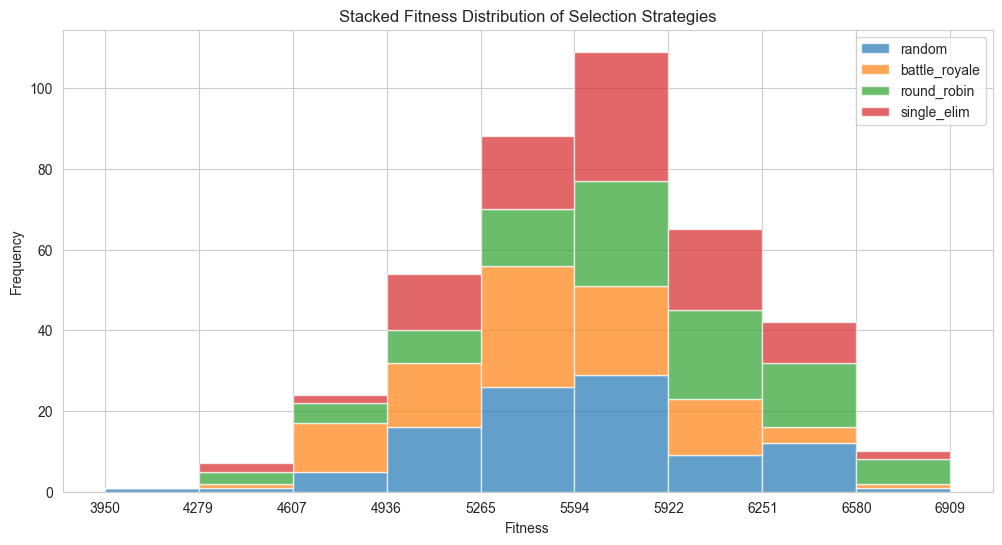

                p-value  follow_normality
random         0.374357              True
battle_royale  0.567593              True
round_robin    0.055867              True
single_elim    0.928606              True True
ANOVA test p-value: 9.054382889457072e-05
       strategy1      strategy2  is_different   p-value
0         random  battle_royale         False  0.260188
1         random    round_robin          True  0.002734
2         random    single_elim         False  0.052417
3  battle_royale    round_robin          True  0.000057
4  battle_royale    single_elim          True  0.001991
5    round_robin    single_elim         False  0.202545


In [70]:
# Plot the fitness distributions
plot_fitness_distribution(df)

# Test for normality
normality_result_df, is_all_follow_normality = test_normality(df)
print(normality_result_df, is_all_follow_normality)

# Perform ANOVA or Kruskal-Wallis Test
anova_or_kruskal, p_value = perform_anova_or_kruskal(df, is_all_follow_normality)
print("ANOVA" if anova_or_kruskal else "Kruskal-Wallis", "test p-value:", p_value)

# Perform pairwise comparisons
pairwise_comparison_results = pairwise_tests(df, is_all_follow_normality)
print(pairwise_comparison_results)

In [71]:
print(normality_result_df.to_latex(float_format="{:.4f}".format).replace('%','\%'))
print(pairwise_comparison_results.to_latex(float_format="{:.4f}".format).replace('%','\%'))


\begin{tabular}{lrl}
\toprule
{} &  p-value &  follow\_normality \\
\midrule
random        &   0.3744 &              True \\
battle\_royale &   0.5676 &              True \\
round\_robin   &   0.0559 &              True \\
single\_elim   &   0.9286 &              True \\
\bottomrule
\end{tabular}

\begin{tabular}{llllr}
\toprule
{} &      strategy1 &      strategy2 &  is\_different &  p-value \\
\midrule
0 &         random &  battle\_royale &         False &   0.2602 \\
1 &         random &    round\_robin &          True &   0.0027 \\
2 &         random &    single\_elim &         False &   0.0524 \\
3 &  battle\_royale &    round\_robin &          True &   0.0001 \\
4 &  battle\_royale &    single\_elim &          True &   0.0020 \\
5 &    round\_robin &    single\_elim &         False &   0.2025 \\
\bottomrule
\end{tabular}



/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/2483374418.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(normality_result_df.to_latex(float_format="{:.4f}".format).replace('%','\%'))
/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/2483374418.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pairwise_comparison_results.to_latex(float_format="{:.4f}".format).replace('%','\%'))


In [73]:
# save scenario 1 best schedule from each strategy
for k, (schedule, fitness) in schedules_dict.items():
    schedule.to_df_class_indexed().to_csv(f"scenario1_{k}_result_classindexed.csv")
    schedule.to_df_professor_indexed().to_csv(f"scenario1_{k}_result_professorindexed.csv")

In [75]:
# print latex for each schedule so that it can be used in report
for k, (schedule, fitness) in schedules_dict.items():
    print(f'-----------------Scenario 1 {k} : Class Indexed-----------------')
    print(schedule.to_df_class_indexed().to_latex(float_format="{:.4f}".format).replace('%','\%').replace('[','\[').replace(']', '\]'))

    print(f'-----------------Scenario 1 {k} : Professor Indexed-----------------')
    print(schedule.to_df_professor_indexed().to_latex(float_format="{:.4f}".format).replace('%','\%').replace('[','\[').replace(']', '\]'))

-----------------Scenario 1 random : Class Indexed-----------------
\begin{tabular}{lllllll}
\toprule
     &   &               Monday &              Tuesday & Wednesday & Thursday & Friday \\
Hour & Class ID &                      &                      &           &          &        \\
\midrule
8 AM & 1 &       \[(Math, Juan)\] &                   \[\] &        \[\] &       \[\] &     \[\] \\
     & 2 &                   \[\] &                   \[\] &        \[\] &       \[\] &     \[\] \\
9 AM & 1 &                   \[\] &                   \[\] &        \[\] &       \[\] &     \[\] \\
     & 2 &       \[(Math, Juan)\] &                   \[\] &        \[\] &       \[\] &     \[\] \\
10 AM & 1 &                   \[\] &       \[(Math, Juan)\] &        \[\] &       \[\] &     \[\] \\
     & 2 &       \[(Math, Juan)\] &                   \[\] &        \[\] &       \[\] &     \[\] \\
11 AM & 1 &                   \[\] &                   \[\] &        \[\] &       \[\] &     \[\] \\


/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/1058779537.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(schedule.to_df_class_indexed().to_latex(float_format="{:.4f}".format).replace('%','\%').replace('[','\[').replace(']', '\]'))
/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/1058779537.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(schedule.to_df_professor_indexed().to_latex(float_format="{:.4f}".format).replace('%

# Scenario 2

Increase the number of professors and courses to create a more complex scheduling problem. Introduce new courses and professors with different availability patterns. This will test the algorithm's ability to handle a larger search space.

In [96]:
# Additional Example Data
time_slots = [(d, t) for d in range(5) for t in range(8)]


# Example data
professors = [
    Professor("Juan", [(d, t) for d in range(5) for t in range(3)]),  # Available Monday-Friday, 8AM-11AM
    Professor("Carlos", [(d, t) for d in range(5) for t in range(3, 8)]), # Available Monday-Friday, 11AM-4PM
    Professor("Maria", [(d, t) for d in range(5) for t in range(5, 8)]),  # Available Monday-Friday, 1PM-4PM
    Professor("Jose", [(d, t) for d in range(5) for t in range(1, 6)])  # Available Monday-Friday, 9AM-2PM
]

courses = [
    Course("Math", [professors[0], professors[1]]),
    Course("Science", [professors[1]]),
    Course("History", [professors[2], professors[3]]),
    Course("Art", [professors[3]])
]

classes = [
    Class("1", 5, [(courses[0], 3), (courses[1], 2)], time_slots.copy()),
    Class("2", 5, [(courses[0], 2), (courses[1], 3)], time_slots.copy()),
    Class("3", 4, [(courses[2], 2), (courses[3], 2)], time_slots.copy()),
    Class("4", 6, [(courses[2], 3), (courses[3], 3)], time_slots.copy()),
]

num_generations = 100
population_size = 50
stale_limit = 10
mutation_rate = 0.1

selection_strategy_tournament = BattleRoyaleTournamentSelection(n_participants=16)

best_schedule_sn2, best_fitness_sn2 = evolutionary_algorithm(classes, professors, courses, num_generations, population_size, stale_limit, mutation_rate, selection_strategy_tournament)

best_schedule.to_df().sort_index().to_csv("result_tourney_scenario2.csv")

print('Best fitness for extended', best_fitness_sn2)


Best fitness for extended 7200.0


True

# Scenario 2 Statistical Test


In [97]:
# increase generations because of more parameters to go through
df, schedules_dict = simulate_multiple_runs_given_configuration_and_strategies(
    classes=classes,
    professors=professors,
    courses=courses,
    num_generations = 200,
    population_size = 50,
    stale_limit = 10,
    mutation_rate = 0.1,
)

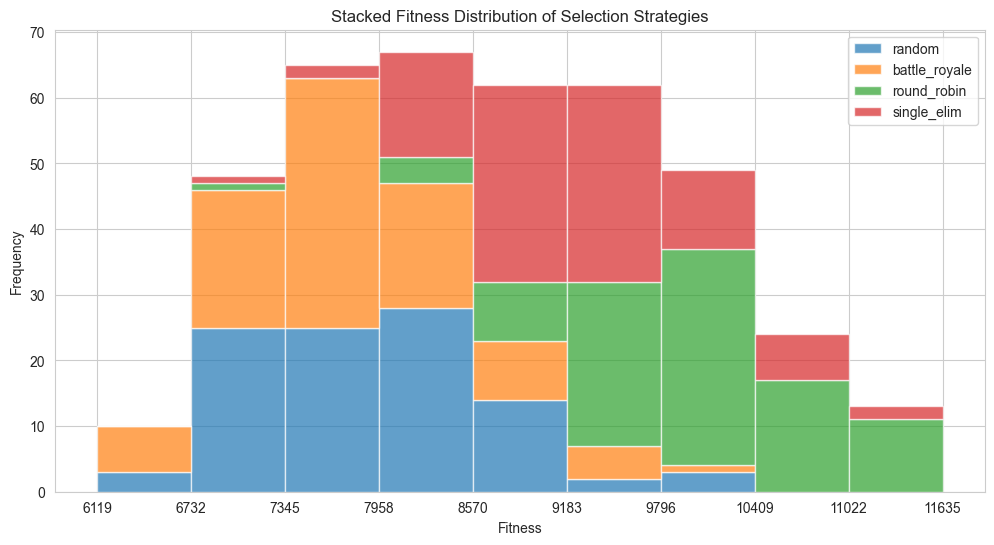

                p-value  follow_normality
random         0.016572             False
battle_royale  0.112628              True
round_robin    0.044963             False
single_elim    0.790835              True False
Kruskal-Wallis test p-value: 6.2965794944056224e-52
       strategy1      strategy2  is_different       p-value
0         random  battle_royale         False  3.356976e-01
1         random    round_robin          True  9.058473e-30
2         random    single_elim          True  7.700347e-22
3  battle_royale    round_robin          True  2.714545e-30
4  battle_royale    single_elim          True  1.885501e-23
5    round_robin    single_elim          True  2.900028e-10


In [98]:
# Plot the fitness distributions
plot_fitness_distribution(df)

# Test for normality
normality_result_df, is_all_follow_normality = test_normality(df)
print(normality_result_df, is_all_follow_normality)

# Perform ANOVA or Kruskal-Wallis Test
anova_or_kruskal, p_value = perform_anova_or_kruskal(df, is_all_follow_normality)
print("ANOVA" if anova_or_kruskal else "Kruskal-Wallis", "test p-value:", p_value)

# Perform pairwise comparisons
pairwise_comparison_results = pairwise_tests(df, is_all_follow_normality)
print(pairwise_comparison_results)

In [99]:
print(normality_result_df.to_latex(float_format="{:.4f}".format).replace('%','\%'))
print(pairwise_comparison_results.to_latex(float_format="{:.4f}".format).replace('%','\%'))


\begin{tabular}{lrl}
\toprule
{} &  p-value &  follow\_normality \\
\midrule
random        &   0.0166 &             False \\
battle\_royale &   0.1126 &              True \\
round\_robin   &   0.0450 &             False \\
single\_elim   &   0.7908 &              True \\
\bottomrule
\end{tabular}

\begin{tabular}{llllr}
\toprule
{} &      strategy1 &      strategy2 &  is\_different &  p-value \\
\midrule
0 &         random &  battle\_royale &         False &   0.3357 \\
1 &         random &    round\_robin &          True &   0.0000 \\
2 &         random &    single\_elim &          True &   0.0000 \\
3 &  battle\_royale &    round\_robin &          True &   0.0000 \\
4 &  battle\_royale &    single\_elim &          True &   0.0000 \\
5 &    round\_robin &    single\_elim &          True &   0.0000 \\
\bottomrule
\end{tabular}



/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/2483374418.py:1: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(normality_result_df.to_latex(float_format="{:.4f}".format).replace('%','\%'))
/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/2483374418.py:2: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pairwise_comparison_results.to_latex(float_format="{:.4f}".format).replace('%','\%'))


In [100]:
# save scenario 2 best schedule from each strategy
for k, (schedule, fitness) in schedules_dict.items():
    schedule.to_df_class_indexed().to_csv(f"scenario2_{k}_result_classindexed.csv")
    schedule.to_df_professor_indexed().to_csv(f"scenario2_{k}_result_professorindexed.csv")

In [101]:
# print latex for each schedule so that it can be used in report
for k, (schedule, fitness) in schedules_dict.items():
    print(f'-----------------Scenario 2 {k} : Class Indexed-----------------')
    print(schedule.to_df_class_indexed().to_latex(float_format="{:.4f}".format).replace('%','\%').replace('[','\[').replace(']', '\]'))

    print(f'-----------------Scenario 2 {k} : Professor Indexed-----------------')
    print(schedule.to_df_professor_indexed().to_latex(float_format="{:.4f}".format).replace('%','\%').replace('[','\[').replace(']', '\]'))

-----------------Scenario 2 random : Class Indexed-----------------
\begin{tabular}{lllllll}
\toprule
     &   &               Monday &              Tuesday &            Wednesday & Thursday & Friday \\
Hour & Class ID &                      &                      &                      &          &        \\
\midrule
8 AM & 1 &                   \[\] &                   \[\] &                   \[\] &       \[\] &     \[\] \\
     & 2 &                   \[\] &                   \[\] &                   \[\] &       \[\] &     \[\] \\
     & 3 &                   \[\] &                   \[\] &                   \[\] &       \[\] &     \[\] \\
     & 4 &                   \[\] &                   \[\] &                   \[\] &       \[\] &     \[\] \\
9 AM & 1 &                   \[\] &       \[(Math, Juan)\] &                   \[\] &       \[\] &     \[\] \\
     & 2 &                   \[\] &                   \[\] &                   \[\] &       \[\] &     \[\] \\
     & 3 &    

/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/3643583621.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(schedule.to_df_class_indexed().to_latex(float_format="{:.4f}".format).replace('%','\%').replace('[','\[').replace(']', '\]'))
/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/3643583621.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(schedule.to_df_professor_indexed().to_latex(float_format="{:.4f}".format).replace('%

\begin{tabular}{lllllll}
\toprule
     &      &          Monday &         Tuesday &       Wednesday & Thursday & Friday \\
Hour & Professor ID &                 &                 &                 &          &        \\
\midrule
8 AM & Juan &              \[\] &     \[(Math, 2)\] &              \[\] &       \[\] &     \[\] \\
     & Carlos &              \[\] &              \[\] &              \[\] &       \[\] &     \[\] \\
     & Maria &              \[\] &              \[\] &              \[\] &       \[\] &     \[\] \\
     & Jose &              \[\] &              \[\] &              \[\] &       \[\] &     \[\] \\
9 AM & Juan &              \[\] &              \[\] &              \[\] &       \[\] &     \[\] \\
     & Carlos &              \[\] &              \[\] &              \[\] &       \[\] &     \[\] \\
     & Maria &              \[\] &              \[\] &              \[\] &       \[\] &     \[\] \\
     & Jose &              \[\] &      \[(Art, 4)\] &              \[\] 

/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/3643583621.py:4: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(schedule.to_df_class_indexed().to_latex(float_format="{:.4f}".format).replace('%','\%').replace('[','\[').replace(']', '\]'))
/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/3643583621.py:7: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(schedule.to_df_professor_indexed().to_latex(float_format="{:.4f}".format).replace('%

# Scenario 3

In [86]:
# Additional Example Data
time_slots = [(d, t) for d in range(5) for t in range(8)]


# Example data
professors = [
    Professor("Juan", [(d, t) for d in range(5) for t in range(3)] + [(d, t) for d in range(2) for t in range(5, 8)]),
    Professor("Carlos", [(d, t) for d in range(5) for t in range(3, 8)]),
    Professor("Maria", [(d, t) for d in range(5) for t in range(5, 8)]),
    Professor("Wit", [(d, t) for d in range(3) for t in range(0, 8)]),
    Professor("Sia", [(d, t) for d in range(5) for t in range(1, 6)]),
    Professor("Mina", [(d, t) for d in range(4) for t in range(3, 8)]),
    Professor("Lebron", [(d, t) for d in range(5) for t in range(0, 6)])
]

courses = [
    Course("Math", [professors[0], professors[1]]),
    Course("Science", [professors[0], professors[1]]),
    Course("History", [professors[2], professors[3]]),
    Course("Art", [professors[5]]),
    Course("English", [professors[4]]),
    Course("PE", [professors[6]])
]

classes = [
    Class("1", 18, [(courses[0], 4),
                   (courses[1], 4),
                   (courses[2], 4),
                   (courses[4], 4),
                   (courses[5], 2)], time_slots.copy()),
    Class("2", 18, [(courses[0], 4),
                   (courses[1], 4),
                   (courses[3], 4),
                   (courses[4], 4),
                   (courses[5], 2)], time_slots.copy()),
    Class("3", 18, [(courses[0], 4),
                   (courses[2], 4),
                   (courses[3], 4),
                   (courses[4], 4),
                   (courses[5], 2)], time_slots.copy()),
    Class("4", 18, [(courses[1], 4),
                   (courses[2], 4),
                   (courses[3], 4),
                   (courses[4], 4),
                   (courses[5], 2)], time_slots.copy()),
]

In [90]:
num_generations=200
population_size=50
stale_limit=5
mutation_rate=0.1

selection_strategy_tournament = BattleRoyaleTournamentSelection(n_participants=16)

best_schedule_sn2, best_fitness_sn2 = evolutionary_algorithm(classes, professors, courses, num_generations, population_size, stale_limit, mutation_rate, selection_strategy_tournament)

best_schedule_sn2.to_df_class_indexed().to_csv("result_tourney_scenario3_class.csv")
best_schedule_sn2.to_df_professor_indexed().to_csv("result_tourney_scenario3_prof.csv")

print('Best fitness for extended', best_fitness_sn2)


Best fitness for extended 768.2745938317889


In [91]:
test_initial_schedule_generation(10000, classes, professors, courses, 10)


True

In [92]:
# increase generations because of more parameters to go through
df, schedules_dict = simulate_multiple_runs_given_configuration_and_strategies(
    classes=classes,
    professors=professors,
    courses=courses,
    num_generations=300,
    population_size=50,
    stale_limit=5,
    mutation_rate=0.1,
)



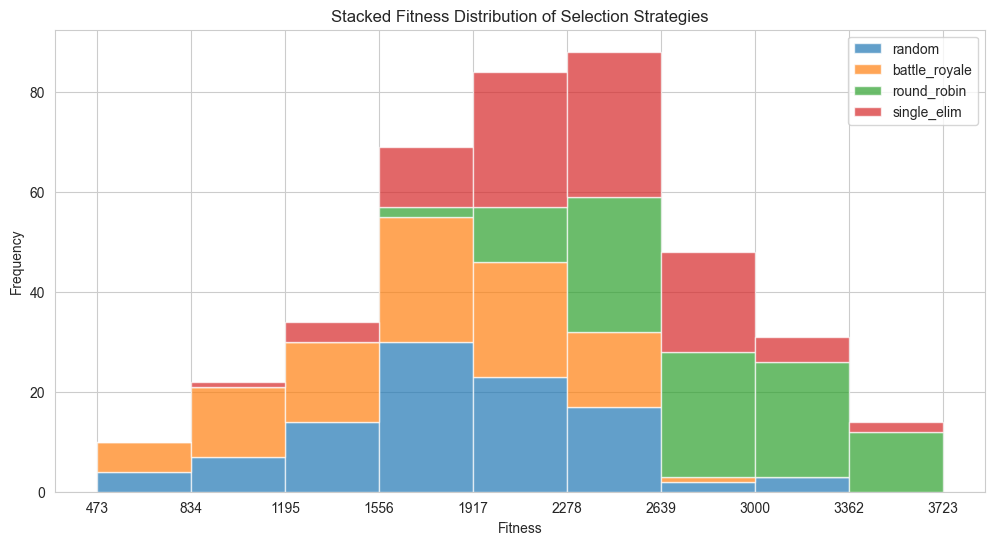

In [93]:
# Plot the fitness distributions
plot_fitness_distribution(df)


In [94]:
# Test for normality
normality_result_df, is_all_follow_normality = test_normality(df)
print(normality_result_df, is_all_follow_normality)

# Perform ANOVA or Kruskal-Wallis Test
anova_or_kruskal, p_value = perform_anova_or_kruskal(df, is_all_follow_normality)
print("ANOVA" if anova_or_kruskal else "Kruskal-Wallis", "test p-value:", p_value)

# Perform pairwise comparisons
pairwise_comparison_results = pairwise_tests(df, is_all_follow_normality)
print(pairwise_comparison_results)
print(normality_result_df.to_latex(float_format="{:.4f}".format).replace('%', '\%'))
print(pairwise_comparison_results.to_latex(float_format="{:.4f}".format).replace('%', '\%'))



                p-value  follow_normality
random         0.548113              True
battle_royale  0.211415              True
round_robin    0.261134              True
single_elim    0.995455              True True
ANOVA test p-value: 1.1307030223255964e-45
       strategy1      strategy2  is_different       p-value
0         random  battle_royale          True  4.574824e-02
1         random    round_robin          True  6.671492e-28
2         random    single_elim          True  7.053608e-10
3  battle_royale    round_robin          True  3.251933e-35
4  battle_royale    single_elim          True  1.031527e-15
5    round_robin    single_elim          True  7.437246e-11
\begin{tabular}{lrl}
\toprule
{} &  p-value &  follow\_normality \\
\midrule
random        &   0.5481 &              True \\
battle\_royale &   0.2114 &              True \\
round\_robin   &   0.2611 &              True \\
single\_elim   &   0.9955 &              True \\
\bottomrule
\end{tabular}

\begin{tabular}{llllr}


/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/828686809.py:12: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(normality_result_df.to_latex(float_format="{:.4f}".format).replace('%', '\%'))
/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/828686809.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(pairwise_comparison_results.to_latex(float_format="{:.4f}".format).replace('%', '\%'))


In [95]:
# save scenario 3 best schedule from each strategy
for k, (schedule, fitness) in schedules_dict.items():
    schedule.to_df_class_indexed().to_csv(f"scenario3_{k}_result_classindexed.csv")
    schedule.to_df_professor_indexed().to_csv(f"scenario3_{k}_result_professorindexed.csv")
# print latex for each schedule so that it can be used in report
for k, (schedule, fitness) in schedules_dict.items():
    print(f'-----------------Scenario 3 {k} : Class Indexed-----------------')
    print(schedule.to_df_class_indexed().to_latex(float_format="{:.4f}".format).replace('%', '\%').replace('[',
                                                                                                           '\[').replace(
        ']', '\]'))

    print(f'-----------------Scenario 3 {k} : Professor Indexed-----------------')
    print(schedule.to_df_professor_indexed().to_latex(float_format="{:.4f}".format).replace('%', '\%').replace('[',
                                                                                                               '\[').replace(
        ']', '\]'))

-----------------Scenario 3 random : Class Indexed-----------------
\begin{tabular}{lllllll}
\toprule
     &   &               Monday &              Tuesday &            Wednesday &             Thursday &            Friday \\
Hour & Class ID &                      &                      &                      &                      &                   \\
\midrule
8 AM & 1 &     \[(History, Wit)\] &                   \[\] &       \[(Math, Juan)\] &       \[(PE, Lebron)\] &                \[\] \\
     & 2 &       \[(Math, Juan)\] &                   \[\] &                   \[\] &                   \[\] &    \[(PE, Lebron)\] \\
     & 3 &                   \[\] &       \[(Math, Juan)\] &                   \[\] &                   \[\] &                \[\] \\
     & 4 &       \[(PE, Lebron)\] &                   \[\] &                   \[\] &    \[(Science, Juan)\] &                \[\] \\
9 AM & 1 &                   \[\] &     \[(History, Wit)\] &                   \[\] &       \[(PE,

/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/1586630470.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(schedule.to_df_class_indexed().to_latex(float_format="{:.4f}".format).replace('%', '\%').replace('[',
/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/1586630470.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(schedule.to_df_professor_indexed().to_latex(float_format="{:.4f}".format).replace('%', '\%').replace('[',
/

\begin{tabular}{lllllll}
\toprule
     &        &          Monday &         Tuesday &       Wednesday &        Thursday &          Friday \\
Hour & Professor ID &                 &                 &                 &                 &                 \\
\midrule
8 AM & Juan &              \[\] &     \[(Math, 1)\] &  \[(Science, 2)\] &     \[(Math, 3)\] &  \[(Science, 2)\] \\
     & Carlos &              \[\] &              \[\] &              \[\] &              \[\] &              \[\] \\
     & Maria &              \[\] &              \[\] &              \[\] &              \[\] &              \[\] \\
     & Wit &              \[\] &              \[\] &              \[\] &              \[\] &              \[\] \\
     & Sia &              \[\] &              \[\] &              \[\] &              \[\] &              \[\] \\
     & Mina &              \[\] &              \[\] &              \[\] &              \[\] &              \[\] \\
     & Lebron &       \[(PE, 1)\] &       \[(P

/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/1586630470.py:8: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(schedule.to_df_class_indexed().to_latex(float_format="{:.4f}".format).replace('%', '\%').replace('[',
/var/folders/8x/t_wy737j52gc95rxfbycpnh80000gn/T/ipykernel_83241/1586630470.py:13: FutureWarning: In future versions `DataFrame.to_latex` is expected to utilise the base implementation of `Styler.to_latex` for formatting and rendering. The arguments signature may therefore change. It is recommended instead to use `DataFrame.style.to_latex` which also contains additional functionality.
  print(schedule.to_df_professor_indexed().to_latex(float_format="{:.4f}".format).replace('%', '\%').replace('[',
/

\begin{tabular}{lllllll}
\toprule
     &        &          Monday &         Tuesday &       Wednesday &        Thursday &          Friday \\
Hour & Professor ID &                 &                 &                 &                 &                 \\
\midrule
8 AM & Juan &  \[(Science, 4)\] &  \[(Science, 4)\] &     \[(Math, 1)\] &     \[(Math, 2)\] &              \[\] \\
     & Carlos &              \[\] &              \[\] &              \[\] &              \[\] &              \[\] \\
     & Maria &              \[\] &              \[\] &              \[\] &              \[\] &              \[\] \\
     & Wit &              \[\] &              \[\] &  \[(History, 3)\] &              \[\] &              \[\] \\
     & Sia &              \[\] &              \[\] &              \[\] &              \[\] &              \[\] \\
     & Mina &              \[\] &              \[\] &              \[\] &              \[\] &              \[\] \\
     & Lebron &       \[(PE, 3)\] &           